# 🎉 Graph Neural Network Classification Architectures for Mutagenic Molecule Detection 🎉

Emmanouil Chatzakis (emmanouil.chatzakis@epfl.ch)

October 2023, EPFL

In this notebook, we employ Graph Neural Networks (GNNs) classify molecule data as mutagenic (positive class) or non-mutagenic (negative class). For our training and testing, we use the MUTAG dataset, a collection of 188 molecule graphs, labelled as either mutagenic or non mutagenic. The nodes of the graphs included in the dataset represent atoms, while the edges represent chemical bonds between them. 

Every node of MUTAG is associated with a collection of features (node features), describing the atom (7 features per node). In addition, every edge is associated with a collection of features (4 features per edge) describing the bond (edge features).

## Contents 👨🏽‍💻



The notebook is partioned in three parts:

- Part 1: Definition and implementation of different Graph Neural Network layers, including Normal Convolution, GraphSAGE and Graph Attention. 

- Part 2: Tuning, Training and Testing of the different architectures for graph classification, using only the node features provided by MUTAG. 

- Part 3: Implementation and Evaluation of a solution to incorporate the edge features provided by MUTAG.

##### Here we importing the libraries, make sure that the latest versions of them are installed.

In [2]:
import numpy as np

import random
import torch

import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from torch.utils.data import DataLoader

# Local imports
import train_utils
import utils

# Set the seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Make sure changes to external files are automatically reloaded
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Implementing Different Graph Convolution and Pooling Layers 👨🏽‍💻

In this part, we implement different Graph Neural Network layers in pure PyTorch (without geometric). We implement 3 basic graph layers, including Normal Graph Convolution, GraphSAGE and Graph Attention.

In addition, we implement pooling layers, including Mean and Max pooling, to be used with GraphSAGE as aggregation modules.

### Normal Convolution Layer

A layer performing basic graph convolution by aggregating the node features of the neighbors of each node.

In [3]:
class GraphConv(nn.Module):
    """
    Basic graph convolutional layer implementing the simple neighborhood aggregation.
    """

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.

        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional), e.g. nn.ReLU().
        """
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation

        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

    def forward(self, H, adj):
        """
        Perform graph convolution operation.

        Args:
            H (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # Neighbourhood aggregation: This versions normalizes the adjacency matrix by diving each row with the
        # neiggbors of the corresponding node.
        # Clamp is used to avoid division by zero.
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)

        # Aggregation is performed by multiplying the adjacency matrix with the node features
        x_agg = torch.matmul(adj, H)

        # Perform graph convolution
        output = self.weight(x_agg) + self.bias(H)

        # Apply activation function (e.g., ReLU) if given
        if self.activation is not None:
            output = self.activation(output)

        return output

In [4]:
# Test that the layer is operational
features = 7
nodes = 5
adj = torch.randint(0, 2, (nodes, nodes)).float()
h = torch.rand(nodes, features)

print("Adj Shape:", adj.shape)
print("h Shape:", h.shape)
print()

conv = GraphConv(features, 2)
out = conv.forward(h, adj)

print("Output Shape:", out.shape)
print(out)

Adj Shape: torch.Size([5, 5])
h Shape: torch.Size([5, 7])

Output Shape: torch.Size([5, 2])
tensor([[ 0.0852,  0.3782],
        [-0.3630,  0.1931],
        [-0.0945,  0.2055],
        [-0.6086, -0.1176],
        [-0.3996,  0.1187]], grad_fn=<AddBackward0>)


### Pooling Layers

Here we implement two basic pooling layers, which apply Mean and Max neighborhood aggregation.

In [5]:
class MeanPoolAggregation(nn.Module):
    """
    Aggregate node features by averaging over the neighborhood.
    """

    def __init__(self):
        super().__init__()

    def forward(self, H, adj):
        """Perform mean pooling over the neighborhood.


        Args:
            H (tensor): node features of shape (num_nodes, num_features).
            adj (tensor): adjacency matrix of shape (num_nodes, num_nodes).

        Returns:
            tensor (num_nodes, num_features): aggregated node features.
        """

        # Normalize the adjacency matrix
        degree = torch.sum(adj, dim=1, keepdim=True).clamp(min=1)
        adj = adj / degree

        # Aggregate neighborhood information using mean
        x_agg = torch.matmul(adj, H)
        return x_agg


class MaxPoolAggregation(nn.Module):
    """
    Aggregate node features by taking the maximum over the transformed neighborhood.
    """

    def __init__(self):
        super().__init__()

    def forward(self, H, adj):
        """Perform max pooling over the neighborhood.


        Args:
            H (tensor): node features of shape (num_nodes, num_features).
            adj (tensor): adjacency matrix of shape (num_nodes, num_nodes).

        Returns:
            tensor (num_nodes, num_features): aggregated node features.
        """

        # Aggregate neighborhood information using max-pooling
        edge_index = torch.triu(adj).nonzero(as_tuple=False).t()
        x_agg = torch.zeros_like(H)

        # Loop on all nodes
        for i in range(x_agg.shape[0]):
            neighbors = H[edge_index[1, edge_index[0] == i]]
            if neighbors.shape[0] > 0:
                x_agg[i] = neighbors.max(dim=0)[0]

        return x_agg

In [6]:
# Test that max and mean pooling layers are operational
features = 5
nodes = 3
adj = torch.randint(0, 2, (nodes, nodes)).float()
h = torch.rand(nodes, features)

print("h Shape:", h.shape)
print(h)

print()

meanPool = MeanPoolAggregation()
maxPool = MaxPoolAggregation()

print("Mean Pooling")
print(meanPool.forward(h, adj))

print()

print("Max Pooling")
print(maxPool.forward(h, adj))

h Shape: torch.Size([3, 5])
tensor([[0.3313, 0.3227, 0.0162, 0.2137, 0.6249],
        [0.4340, 0.1371, 0.5117, 0.1585, 0.0758],
        [0.2247, 0.0624, 0.1816, 0.9998, 0.5944]])

Mean Pooling
tensor([[0.3300, 0.1741, 0.2365, 0.4573, 0.4317],
        [0.3300, 0.1741, 0.2365, 0.4573, 0.4317],
        [0.3300, 0.1741, 0.2365, 0.4573, 0.4317]])

Max Pooling
tensor([[0.4340, 0.3227, 0.5117, 0.9998, 0.6249],
        [0.4340, 0.1371, 0.5117, 0.9998, 0.5944],
        [0.2247, 0.0624, 0.1816, 0.9998, 0.5944]])


### GraphSAGE Layer

Here we imlpement the concat-based GraphSAGE layer, which uses an aggregation operation in the neighborhood of a node, and concats the aggregated neighbor features with the features of the node. 

In [7]:
class GraphSAGEConv(nn.Module):
    """GraphSAGE convolutional layer."""

    def __init__(self, in_features, out_features, aggregation, activation=None):
        """
        Initialize the GraphSAGE convolutional layer.

        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            aggregation (nn.Module or callable): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.aggregation = aggregation
        self.activation = activation

        # Because of the concat performed by this layer, the input dimension for
        # the weight is twice the number of input features
        self.weight = nn.Linear(2 * in_features, out_features, bias=False)

    def forward(self, H, adj):
        """
        Perform graph convolution operation.

        Args:
            H (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # print(f"Forward start. Feature shape:{H.shape}")

        # Perform the selected aggregation to the features matrix
        agg_features = self.aggregation(H, adj)

        # Concat the agreegated features with the original features
        concat_features = torch.cat((H, agg_features), dim=1)

        # Perform graph convolution
        output = self.weight(concat_features)

        # Apply activation function (e.g., ReLU) if given
        if self.activation is not None:
            output = self.activation(output)

        return output

In [8]:
# Check that the layer is operational
features = 7
nodes = 5
adj = torch.randint(0, 2, (nodes, nodes)).float()
h = torch.rand(nodes, features)

print("Adj Shape:", adj.shape)
print("h Shape:", h.shape)
print()

sage = GraphSAGEConv(features, 2, MeanPoolAggregation(), nn.ReLU())
output = sage(h, adj)

print("Output Shape:", output.shape)
print(output)

Adj Shape: torch.Size([5, 5])
h Shape: torch.Size([5, 7])

Output Shape: torch.Size([5, 2])
tensor([[0.0643, 0.0000],
        [0.0000, 0.1195],
        [0.2484, 0.1580],
        [0.0434, 0.2160],
        [0.0000, 0.0326]], grad_fn=<ReluBackward0>)


### Attention-based Convolution Layer

In [9]:
class GraphAttnConv(nn.Module):
    """
    Implementation of the graph attentional convolutional layer.
    """

    def __init__(self, in_features, out_features, activation=None):
        """Initialize the graph convolutional layer.

        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional), e.g. nn.ReLU().
        """
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation

        # Weight or S parameter of the attention mechanism
        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))

        # Alpha parameter of the attention mechanism
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))

        # In bibliography, Weights and Alpha are initialized like this
        # Without initialization, the outputs of the layer were 0
        nn.init.xavier_uniform_(self.W.data)
        nn.init.xavier_uniform_(self.a.data)

        # LeakyReLU activation is used for attention
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, H, adj):
        """Perform a forward pass of graph attentional convolution.

        Args:
            H (tensor): Node features of shape (num_nodes, in_features).
            adj (tensor): Adjacency matrix of shape (num_nodes, num_nodes).

        Returns:
            tensor: Attention-processed features of shape (num_nodes, out_features).
        """

        # Step 1: Calculate H' = WH as in the formlula
        Wh = torch.mm(H, self.W)

        # Step 2: Calculate the attention score e
        Wh1 = torch.matmul(Wh, self.a[: self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features :, :])
        e = self.leakyrelu(Wh1 + Wh2.T)

        # Step 3: Calculate the attention weights a
        zero_vec = -9e15 * torch.ones_like(
            e
        )  # Use as an almost zero value for the attention weights (trick that improved performance)
        a = torch.where(adj > 0, e, zero_vec)
        a = torch.nn.functional.softmax(a, dim=1)

        # Step 4: Calculate the output of the layer using the attention weights
        out = torch.matmul(a, Wh)

        # Step 5: Apply activation function (e.g., ReLU) if given
        if self.activation is not None:
            out = self.activation(out)

        return out

In [10]:
# Some minimalistic testing

FEATURES = 5
NODES = 7
OUT_FEATURES = 4

adj = torch.randint(0, 2, (NODES, NODES)).float()
h = torch.rand(NODES, FEATURES)

print("Adj Shape:", adj.shape)
print(adj)
print()

print("h Shape:", h.shape)
print(h)
print()

gat1 = GraphAttnConv(FEATURES, OUT_FEATURES)
gat2 = GraphAttnConv(OUT_FEATURES, 2)

output1 = gat1(h, adj)
output2 = gat2(output1, adj)

print("Output Shape:", output2.shape)
print(output2)

Adj Shape: torch.Size([7, 7])
tensor([[0., 1., 0., 0., 1., 0., 1.],
        [1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 1., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 0., 0., 0.]])

h Shape: torch.Size([7, 5])
tensor([[0.8087, 0.3396, 0.1332, 0.4118, 0.2576],
        [0.3470, 0.0240, 0.7797, 0.1519, 0.7513],
        [0.7269, 0.8572, 0.1165, 0.8596, 0.2636],
        [0.6855, 0.9696, 0.4295, 0.4961, 0.3849],
        [0.0825, 0.7400, 0.0036, 0.8104, 0.8741],
        [0.9729, 0.3821, 0.0892, 0.6124, 0.7762],
        [0.0023, 0.3865, 0.2003, 0.4563, 0.2539]])

Output Shape: torch.Size([7, 2])
tensor([[-0.6916, -0.9793],
        [-0.4357, -0.8214],
        [-0.7577, -0.9667],
        [-0.6931, -0.9524],
        [-0.7329, -0.9733],
        [-0.6110, -0.9237],
        [-0.4925, -0.7648]], grad_fn=<MmBackward0>)


### Layers are ready! Lets check if they can be stacked together!

In [12]:
# Make an overall test to stack the layers
FEATURES = 3
NODES = 6

adj = torch.randint(0, 2, (NODES, NODES)).float()
h = torch.rand(NODES, FEATURES)

print("Adj Shape:", adj.shape)
print(adj)
print()

print("h Shape:", h.shape)
print(h)
print()

conv1 = GraphConv(FEATURES, 8)
conv2 = GraphConv(8, 4)
gat1 = GraphAttnConv(4, 3)
sage1 = GraphSAGEConv(3, 7, MeanPoolAggregation())

conv1_out = conv1(h, adj)
conv2_out = conv2(conv1_out, adj)
gat1_out = gat1(conv2_out, adj)
sage1_out = sage1(gat1_out, adj)

print(sage1_out.shape)
print(sage1_out)

Adj Shape: torch.Size([6, 6])
tensor([[0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1., 0.]])

h Shape: torch.Size([6, 3])
tensor([[0.2088, 0.4931, 0.5275],
        [0.6227, 0.6943, 0.9345],
        [0.1184, 0.5150, 0.2502],
        [0.1045, 0.4600, 0.0599],
        [0.8489, 0.5579, 0.2305],
        [0.7613, 0.0268, 0.3066]])

torch.Size([6, 7])
tensor([[-0.1948, -0.0072, -0.0015,  0.1047, -0.1344,  0.1674, -0.0635],
        [-0.2173, -0.0034, -0.0029,  0.1106, -0.1421,  0.1600, -0.0741],
        [-0.2193, -0.0182, -0.0536,  0.1596, -0.1260,  0.2203, -0.0928],
        [-0.2003, -0.0250, -0.0455,  0.1549, -0.1288,  0.2229, -0.0852],
        [-0.2166, -0.0067, -0.0166,  0.1205, -0.1333,  0.1784, -0.0767],
        [-0.2301, -0.0090, -0.0357,  0.1426, -0.1339,  0.1919, -0.0905]],
       grad_fn=<MmBackward0>)


That was it for part 1!

## Part 2: Custom Network Design with Node Features 👨🏽‍💻

In this part, we will load and process the data, and experiment with the layers of the previous part using only the node features of the dataset.

### Define the Graph Neural Network Model

We define a PyTorch module representing a tunable Graph Neural Network. The network can use all type of layers, both as single layer architectures or combinations of them.

By default, the Normal Convolution Layers are first, then the Attention Layers and GraphSAGE layers last. Feel free to change the order! 

In [13]:
class GNN(nn.Module):
    """Module representing a full graph neural network."""

    def __init__(
        self,
        num_features,
        num_classes,
        normal_conv_dims,
        attn_dims,
        sage_data,
        dropout=0.2,
        name=None,
    ):
        """Initialize a custom graph neural network.

        Args:
            num_features (int): The number of input features.
            num_classes (int): The number of classification classes.
            normal_conv_dims (list of ints): The dimensions of the hidden layers of the normal convolutions.
            attn_dims (list of ints): The dimensions of the hidden layers of the attention convolutions.
            sage_data (list of ints): The dimensions of the hidden layers of the GraphSAGE convolutions.
            dropout (float, optional): Dropout rate. Defaults to 0.2.
            name (str, optional): An optional name for the model. Used for Testing. Defaults to None.
                If none is selected, the model will auto-generate a name based on its parameters.
        """
        super().__init__()

        self.dropout = dropout
        self.num_features = num_features
        self.num_classes = num_classes
        self.normal_conv_dims = normal_conv_dims
        self.attn_dims = attn_dims
        self.sage_data = sage_data

        # Add all the layers to the module list
        next_dim_size = num_features

        self.conv_layers = nn.ModuleList()
        for dim in normal_conv_dims:
            self.conv_layers.append(GraphConv(next_dim_size, dim, nn.ReLU()))
            next_dim_size = dim

        for dim in attn_dims:
            self.conv_layers.append(GraphAttnConv(next_dim_size, dim, nn.ReLU()))
            next_dim_size = dim

        for dim, aggr in sage_data:
            self.conv_layers.append(GraphSAGEConv(next_dim_size, dim, aggr, nn.ReLU()))
            next_dim_size = dim

        # Add the final linear layer for predictions
        self.head = nn.Linear(next_dim_size, num_classes)

        # Generate the name of the model used for testing
        if name == None:
            self.name = self._generate_network_name()
        else:
            self.name = name

    def forward(self, X, adj):
        """Perform a forward pass of the model.

        Args:
            X (tensor): Input features of shape (num_nodes, num_features).
            adj (tensor): Adjacency matrix of shape (num_nodes, num_nodes).

        Returns:
            tensor: Output logits in the shape (1, num_classes)
        """

        # Perform the forward pass of all the graph convolution layers
        for layer in self.conv_layers:
            X = layer(X, adj)

        # print("X shape before pool", X.shape)

        # Transform the node features into a flattened representation to pass to the linear layer
        # The "flattening" is just the mean, transforming X from (num_nodes, num_features) to (1, num_features)
        X = utils.avg_pool(X)

        # Perform dropout (by default we use it here)
        X = torch.nn.functional.dropout(X, p=self.dropout, training=self.training)

        # Perform the linear forward to generate the logits
        X = self.head(X)

        return X

    def _generate_network_name(self):
        """Generate the model name based on its parameters.

        Returns:
            str: name of the model
        """
        name = ""

        if self.normal_conv_dims:
            name += "Conv"
            for dim in self.normal_conv_dims:
                name += f"-{dim}"

        if self.attn_dims:
            name += "Attn"
            for dim in self.attn_dims:
                name += f"-{dim}"

        if self.sage_data:
            name += "Sage"
            for dim, _ in self.sage_data:
                name += f"-{dim}"

        return name

In [14]:
# Some testing to see that the module is operational
FEATURES = 450
NODES = 418

adj = torch.randint(0, 2, (NODES, NODES)).float()
h = torch.rand(NODES, FEATURES)

print("Adj Shape:", adj.shape)
print(adj)

print("h Shape:", h.shape)

n = GNN(FEATURES, 2, [512, 128], [64, 32], [(32, MeanPoolAggregation())])

logits = n(h, adj)

probs = torch.softmax(logits, dim=1)
argmax_index = torch.argmax(probs)

print("Logits Shape:", logits.shape)
print("Logits:", logits)

print("Softmax:", probs)

print("Class:", argmax_index)

Adj Shape: torch.Size([418, 418])
tensor([[0., 1., 1.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]])
h Shape: torch.Size([418, 450])
Logits Shape: torch.Size([1, 2])
Logits: tensor([[-0.1858,  0.0486]], grad_fn=<AddmmBackward0>)
Softmax: tensor([[0.4417, 0.5583]], grad_fn=<SoftmaxBackward0>)
Class: tensor(1)


### Load data and create training, validation and test sets.

We load the MUTAG data. For this verion of the notebook, we discard some mutagenic graph to balance the number of demonstrations of positive and negative classes to ensure stability during training. 

During loading, we also calculate the adj matrix from the edge list provided for each graph. For each graph example, we have two versions of the adj matrix. The raw version is the matrix as it is (without 1s in the diagonal) while the processed versioned contains 1s in the diagonal to ensure that the features of each node are used in convolution.

In [15]:
# Load the data and discard some mutagenic graphs to balance the dataset
# When loading the data, we calculate the adj matrix
mutag_data = utils.load_and_balance_MUTAG()

# Uncomment the following line to use the unbalanced dataset
# mutag_data = utils.load_MUTAG()

MUTAG_NUM_CLASSES = 2
MUTAG_NUM_FEATURES = mutag_data[0]["node_feat"].shape[1]

# Balanced split
mutag_train, mutag_val, mutag_test = utils.fair_train_test_split(mutag_data, 0.7, 0.15)

# Print some basic stats
print("Number of graphs:", len(mutag_data))
print("Data keys:", mutag_data[0].keys())

print("\nNumber of training graphs:", len(mutag_train))
print("Number of validation graphs:", len(mutag_val))
print("Number of test graphs:", len(mutag_test))

print()
print("Train: (mutagenic, non-mutagenic)", utils.count_classes(mutag_train))
print("Val: (mutagenic, non-mutagenic)", utils.count_classes(mutag_val))
print("Test: (mutagenic, non-mutagenic)", utils.count_classes(mutag_test))

# Define the dataloaders
train_dataloader = DataLoader(mutag_train, batch_size=1, shuffle=True)
val_dataloader = DataLoader(mutag_val, batch_size=1, shuffle=True)
test_dataloader = DataLoader(mutag_test, batch_size=1, shuffle=True)

Found cached dataset json (/Users/manoschatzakis/.cache/huggingface/datasets/graphs-datasets___json/graphs-datasets--MUTAG-a0cf78a2615b5c11/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Number of graphs: 126
Data keys: dict_keys(['edge_index', 'node_feat', 'edge_attr', 'y', 'num_nodes', 'adjacency_matrix', 'adjacency_matrix_raw'])

Number of training graphs: 88
Number of validation graphs: 19
Number of test graphs: 19

Train: (mutagenic, non-mutagenic) (44, 44)
Val: (mutagenic, non-mutagenic) (10, 9)
Test: (mutagenic, non-mutagenic) (9, 10)


### Model Tuning!

Now, we will focus on tuning the hyperparameters of the Graph Neural Network, such as defining good layer size and number, as well as defining the learning rate for each type of layer to be used.

#### Lets try a simple example!

Before starting, we test a simple training loop with a single model to make sure everything works smoothly.

Training GNN: 100%|██████████| 5/5 [00:00<00:00, 20.24epoch/s]

0: Train Loss: 0.7163, Val Loss: 0.7079, Train Accuracy 0.5000, Val Accuracy: 0.4737, Train F1 Score: 0.0000, Val F1 Score: 0.0000
4: Train Loss: 0.5703, Val Loss: 0.7458, Train Accuracy 0.7386, Val Accuracy: 0.5263, Train F1 Score: 0.7629, Val F1 Score: 0.5714


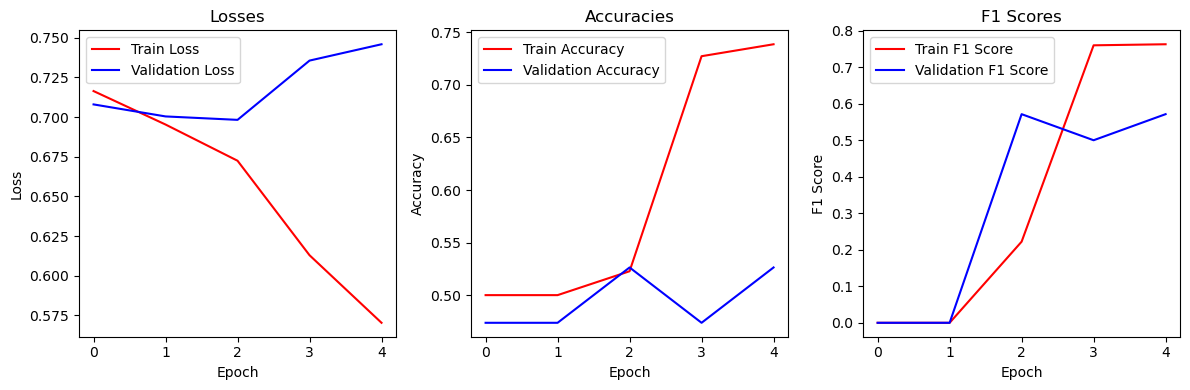

In [16]:
epochs = 5
model = GNN(
    MUTAG_NUM_FEATURES,
    MUTAG_NUM_CLASSES,
    normal_conv_dims=[5, 3],
    attn_dims=[],
    sage_data=[],
    name="Test GNN",
    dropout=0.3,
)

criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
results = train_utils.train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs,
    criterion,
    optimizer,
    verbose=True,
)

test_acc, _, test_f1_score, mutagenic, nonmutagenic = train_utils.test(
    test_dataloader, model, criterion
)

utils.plot_training_loop_summary(results, None)

#### Tune the dimensions and layer size of the models

We start our evaluation by comparing the performance of single-type layer combinations of different sizes and numbers, and we keep all the other parameters constant. We keep the best-performing models of each layer type.

>>> Training Conv-256-16-8 model


Training GNN: 100%|██████████| 300/300 [00:17<00:00, 16.88epoch/s]


Model Conv-256-16-8 test accuracy: 0.6316
>>> Training Conv-256-168 model


Training GNN: 100%|██████████| 300/300 [00:25<00:00, 11.85epoch/s]


Model Conv-256-168 test accuracy: 0.6316
>>> Training Conv-16-4 model


Training GNN: 100%|██████████| 300/300 [00:11<00:00, 25.50epoch/s]


Model Conv-16-4 test accuracy: 0.4737
>>> Training Conv-32-12 model


Training GNN: 100%|██████████| 300/300 [00:11<00:00, 25.14epoch/s]


Model Conv-32-12 test accuracy: 0.4737
===== Best model for conv is Conv-256-16-8 with accuracy 0.631578947368421 =====

>>> Training Attn-32-8 model


Training GNN: 100%|██████████| 300/300 [00:15<00:00, 19.00epoch/s]


Model Attn-32-8 test accuracy: 0.4737
>>> Training Attn-256-16 model


Training GNN: 100%|██████████| 300/300 [00:17<00:00, 17.61epoch/s]


Model Attn-256-16 test accuracy: 0.6316
>>> Training Attn-16-4 model


Training GNN: 100%|██████████| 300/300 [00:15<00:00, 19.07epoch/s]


Model Attn-16-4 test accuracy: 0.6842
>>> Training Attn-32-12 model


Training GNN: 100%|██████████| 300/300 [00:16<00:00, 18.14epoch/s]


Model Attn-32-12 test accuracy: 0.5263
===== Best model for attn is Attn-16-4 with accuracy 0.6842105263157895 =====

>>> Training Sage-32 model


Training GNN: 100%|██████████| 300/300 [00:39<00:00,  7.56epoch/s]


Model Sage-32 test accuracy: 0.5789
>>> Training Sage-32-16 model


Training GNN: 100%|██████████| 300/300 [01:23<00:00,  3.60epoch/s]


Model Sage-32-16 test accuracy: 0.6316
>>> Training Sage-128-8 model


Training GNN: 100%|██████████| 300/300 [01:29<00:00,  3.34epoch/s]


Model Sage-128-8 test accuracy: 0.7895
===== Best model for sage is Sage-128-8 with accuracy 0.7894736842105263 =====

Best performing models metadata: {'conv': [[256, 16, 8], [], [], 'Conv-256-16-8', 1e-05], 'attn': [[], [16, 4], [], 'Attn-16-4', 1e-05], 'sage': [[], [], [(128, MaxPoolAggregation()), (8, MaxPoolAggregation())], 'Sage-128-8', 1e-05]}


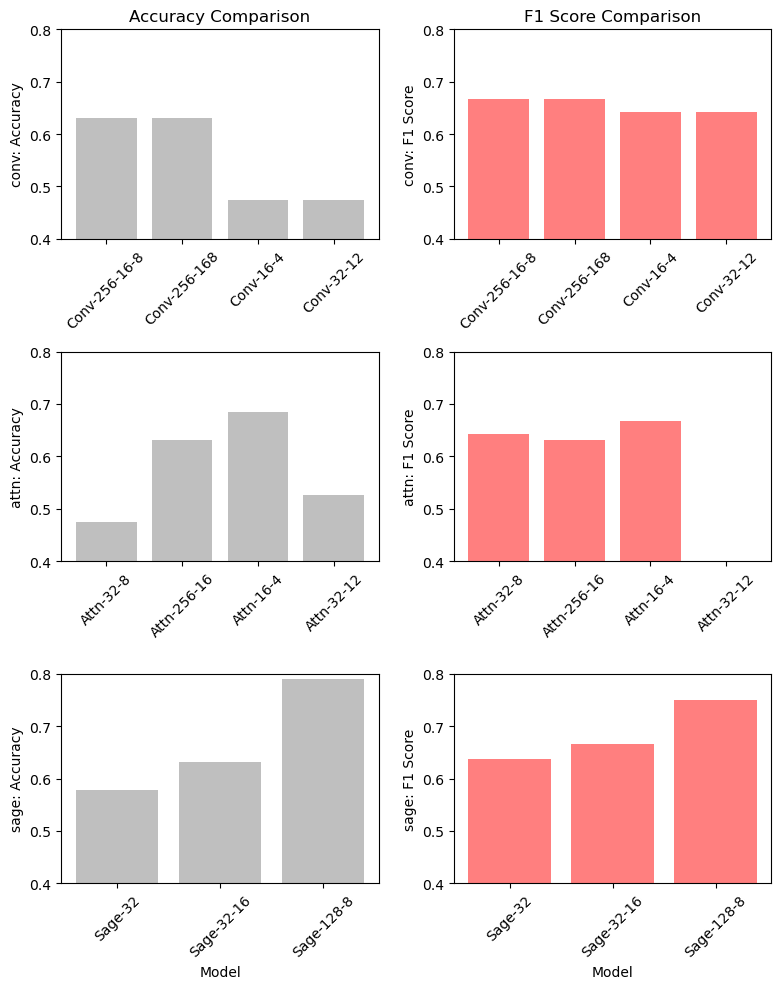

In [17]:
# Make sure to set the seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Define the hyperparameters
epochs = 300
criterion = nn.CrossEntropyLoss()

# From experimental evaluation with various learning rates, we found that 0.00001 is the best
# Also the usage of scheduler did not lead to better performance
lr = 0.00001

# Heuristically define the models to test
gnn = [
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[256, 16, 8],
        attn_dims=[],
        sage_data=[],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[256, 168],
        attn_dims=[],
        sage_data=[],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[16, 4],
        attn_dims=[],
        sage_data=[],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[32, 12],
        attn_dims=[],
        sage_data=[],
        dropout=0.3,
    ),
]

attn = [
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[],
        attn_dims=[32, 8],
        sage_data=[],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[],
        attn_dims=[256, 16],
        sage_data=[],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[],
        attn_dims=[16, 4],
        sage_data=[],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[],
        attn_dims=[32, 12],
        sage_data=[],
        dropout=0.3,
    ),
]

sage = [
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[],
        attn_dims=[],
        sage_data=[(32, MaxPoolAggregation())],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[],
        attn_dims=[],
        sage_data=[(32, MaxPoolAggregation()), (16, MaxPoolAggregation())],
        dropout=0.3,
    ),
    GNN(
        MUTAG_NUM_FEATURES,
        MUTAG_NUM_CLASSES,
        normal_conv_dims=[],
        attn_dims=[],
        sage_data=[(128, MaxPoolAggregation()), (8, MaxPoolAggregation())],
        dropout=0.3,
    ),
]

# Keep the statistics and the best model params in a dictionary to use later
evaluation_set = {"conv": gnn, "attn": attn, "sage": sage}
best_perfoming_models_metadata = {}

plotting_data = {}

# Start the training and evalution!
for nn_type in evaluation_set:
    accuracies = []
    f1_scores = []
    labels = []

    # Training routine for each model
    for model in evaluation_set[nn_type]:
        print(f">>> Training {model.name} model")

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        # Train the model
        results = train_utils.train_model(
            model,
            train_dataloader,
            val_dataloader,
            epochs,
            criterion,
            optimizer,
            verbose=False,
            # scheduler=scheduler, # Uncomment to use scheduler
        )

        # Test the model
        test_acc, _, test_f1_score, mutagenic, non_mutagenic = train_utils.test(
            test_dataloader, model, criterion
        )

        # Print the result and update stats
        print(f"Model {model.name} test accuracy: {test_acc:.4f}")

        accuracies.append(test_acc)
        f1_scores.append(test_f1_score)
        labels.append(model.name)

    # Find the best model for this type of architecture and keep its params
    best_acc = max(accuracies)
    best_acc_index = accuracies.index(best_acc)
    best_model = evaluation_set[nn_type][best_acc_index]
    print(
        f"===== Best model for {nn_type} is {best_model.name} with accuracy {best_acc} ====="
    )

    best_perfoming_models_metadata[nn_type] = [
        best_model.normal_conv_dims,
        best_model.attn_dims,
        best_model.sage_data,
        best_model.name,
        lr,
    ]

    # Keep the stats for plotting
    plotting_data[nn_type] = [accuracies, f1_scores, labels]

    print()

# Plot the results and print the best models
utils.plot_model_comparison_subfigs(plotting_data)
print("Best performing models metadata:", best_perfoming_models_metadata)

### Evaluation: Compare different architectures

Now that we have an idea of suitable layers, output features and learning rates, we compare the best-performing models of each architecure, as well as combinations of them.


>>>> Training model: Conv-256-16-8


Training GNN: 100%|██████████| 300/300 [00:17<00:00, 17.45epoch/s]


Model Conv-256-16-8 test accuracy: 0.6316 and F1: 0.6316

>>>> Training model: Attn-16-4


Training GNN: 100%|██████████| 300/300 [00:16<00:00, 18.69epoch/s]


Model Attn-16-4 test accuracy: 0.4737 and F1: 0.6429

>>>> Training model: Sage-128-8


Training GNN: 100%|██████████| 300/300 [01:30<00:00,  3.30epoch/s]


Model Sage-128-8 test accuracy: 0.7895 and F1: 0.7500

>>>> Training model: ConvAttn


Training GNN: 100%|██████████| 300/300 [00:27<00:00, 10.82epoch/s]


Model ConvAttn test accuracy: 0.6316 and F1: 0.6316

>>>> Training model: ConvAttnSage


Training GNN: 100%|██████████| 300/300 [01:59<00:00,  2.51epoch/s]


Model ConvAttnSage test accuracy: 0.6316 and F1: 0.6667

>>>> Training model: ConvSage


Training GNN: 100%|██████████| 300/300 [01:59<00:00,  2.52epoch/s]


Model ConvSage test accuracy: 0.7368 and F1: 0.7619

>>>> Training model: AttnSage


Training GNN: 100%|██████████| 300/300 [01:48<00:00,  2.77epoch/s]

Model AttnSage test accuracy: 0.4737 and F1: 0.6429


======== RESULTS =========
Best model: Sage-128-8
Accuracy: 0.7895
F1 Score: 0.7500


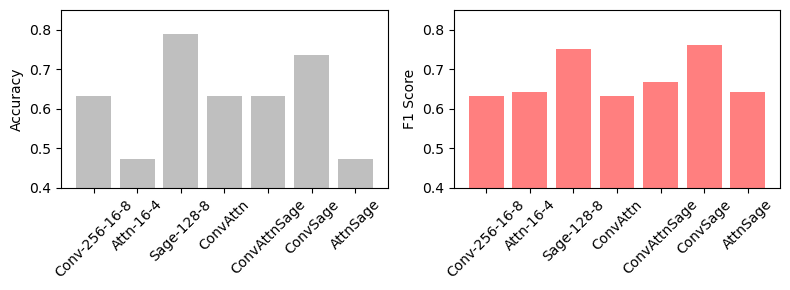

In [18]:
# Lists to keep the performance of the models
accuracies = []
f1_scores = []
labels = []

# Best models for each architecture and combination of them
# The models are stored in the format: (learning_rate, model)
models = [
    (
        best_perfoming_models_metadata["conv"][4],
        GNN(
            num_features=MUTAG_NUM_FEATURES,
            num_classes=MUTAG_NUM_CLASSES,
            normal_conv_dims=best_perfoming_models_metadata["conv"][0],
            attn_dims=best_perfoming_models_metadata["conv"][1],
            sage_data=best_perfoming_models_metadata["conv"][2],
            name=best_perfoming_models_metadata["conv"][3],
        ),
    ),
    (
        best_perfoming_models_metadata["attn"][4],
        GNN(
            num_features=MUTAG_NUM_FEATURES,
            num_classes=MUTAG_NUM_CLASSES,
            normal_conv_dims=best_perfoming_models_metadata["attn"][0],
            attn_dims=best_perfoming_models_metadata["attn"][1],
            sage_data=best_perfoming_models_metadata["attn"][2],
            name=best_perfoming_models_metadata["attn"][3],
        ),
    ),
    (
        best_perfoming_models_metadata["sage"][4],
        GNN(
            num_features=MUTAG_NUM_FEATURES,
            num_classes=MUTAG_NUM_CLASSES,
            normal_conv_dims=best_perfoming_models_metadata["sage"][0],
            attn_dims=best_perfoming_models_metadata["sage"][1],
            sage_data=best_perfoming_models_metadata["sage"][2],
            name=best_perfoming_models_metadata["sage"][3],
        ),
    ),
    (
        best_perfoming_models_metadata["conv"][4],
        GNN(
            num_features=MUTAG_NUM_FEATURES,
            num_classes=MUTAG_NUM_CLASSES,
            normal_conv_dims=best_perfoming_models_metadata["conv"][0],
            attn_dims=best_perfoming_models_metadata["attn"][1],
            sage_data=[],
            name="ConvAttn",
        ),
    ),
    (
        best_perfoming_models_metadata["conv"][4],
        GNN(
            num_features=MUTAG_NUM_FEATURES,
            num_classes=MUTAG_NUM_CLASSES,
            normal_conv_dims=best_perfoming_models_metadata["conv"][0],
            attn_dims=best_perfoming_models_metadata["attn"][1],
            sage_data=best_perfoming_models_metadata["sage"][2],
            name="ConvAttnSage",
        ),
    ),
    (
        best_perfoming_models_metadata["conv"][4],
        GNN(
            num_features=MUTAG_NUM_FEATURES,
            num_classes=MUTAG_NUM_CLASSES,
            normal_conv_dims=best_perfoming_models_metadata["conv"][0],
            attn_dims=[],
            sage_data=best_perfoming_models_metadata["sage"][2],
            name="ConvSage",
        ),
    ),
    (
        best_perfoming_models_metadata["attn"][4],
        GNN(
            num_features=MUTAG_NUM_FEATURES,
            num_classes=MUTAG_NUM_CLASSES,
            normal_conv_dims=[],
            attn_dims=best_perfoming_models_metadata["attn"][1],
            sage_data=best_perfoming_models_metadata["sage"][2],
            name="AttnSage",
        ),
    ),
]

# Retrain and evaluate the best models!
for lr, model in models:
    print(">>>> Training model:", model.name)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Train the model (with the same parameters as before to ensure reproducibility)
    results = train_utils.train_model(
        model,
        train_dataloader,
        val_dataloader,
        epochs,
        criterion,
        optimizer,
        verbose=False,
        # scheduler=scheduler, # Uncomment to use scheduler
    )

    # Test the model and keep the results
    acc, _, f1, _, _ = train_utils.test(test_dataloader, model, criterion)
    print(f"Model {model.name} test accuracy: {acc:.4f} and F1: {f1:.4f}")

    accuracies.append(acc)
    f1_scores.append(f1)
    labels.append(model.name)

    print()

# All the models are trained and evaluated. Lets find the best one and plot the results!
# Find the best model according to the accuracy
best_acc = max(accuracies)
best_acc_index = accuracies.index(best_acc)

print()
print("======== RESULTS =========")
print(f"Best model: {labels[best_acc_index]}")
print(f"Accuracy: {best_acc:.4f}")
print(f"F1 Score: {f1_scores[best_acc_index]:.4f}")

# Plot all!
utils.plot_model_comparison_results(accuracies, f1_scores, labels)

From our evaluation of several different models and architecture combinations, we conclude that the best model is a <b>2-layer GraphSAGE network with output features of 128,8 for each layer, achieving 79% accuracy and 75% f1 score!</b>

## Part 3 : Incorporating Edge Features 👨🏽‍💻

Till now, we have performed our training and prediction using the graph structure and the node features available from MUTAG. Now, we will focus on methods to incorporate the edge features in our predictions. 

### Calculate the per node edge features and create a new feature matrix through concat! 

In [19]:
# Reload the data! (It is easier than to re-run the data-loading cell of part 2)
mutag_data = utils.load_and_balance_MUTAG()

# Uncomment the following line to use the unbalanced dataset
# mutag_data = utils.load_MUTAG()

# Compute and generate edge features per-node
for mutag_graph in tqdm(mutag_data, desc="Generating concat features"):
    # Generate the edge features for each node (as described in the report)
    # Briefly: Create a matrix of the edge features that the node participates in the shape (num_node_edges, num_edge_features)
    # Perform a mean pooling operation to the matrix and transform it to (1, num_edge_features)
    # Concat the generated result to the node features of the node
    per_node_edge_features = utils.generate_per_node_edge_features(mutag_graph)

    node_features = mutag_graph["node_feat"]
    concat_features = torch.cat((node_features, per_node_edge_features), dim=1)

    # Store the new features in the graph sample
    mutag_graph["concat_feats"] = concat_features

print("Generated concat features for all graphs of MUTAG!")

Found cached dataset json (/Users/manoschatzakis/.cache/huggingface/datasets/graphs-datasets___json/graphs-datasets--MUTAG-a0cf78a2615b5c11/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Generating concat features: 100%|██████████| 126/126 [00:01<00:00, 112.85it/s]

Generated concat features for all graphs of MUTAG!


### Re-create the train-test-split sets for the dataset!

Since we reloaded the data, we need to recreate the testing sets! As seeds are set to a constant value, the sets will be the same as part 2.

In [20]:
# Define the new number of features and classes, and split the data
MUTAG_NUM_CLASSES = 2
MUTAG_NUM_FEATURES = mutag_data[0]["concat_feats"].shape[1]

mutag_train, mutag_val, mutag_test = utils.fair_train_test_split(mutag_data, 0.7, 0.15)

# Print some stats
print("Number of graphs:", len(mutag_data))
print("Number of training graphs:", len(mutag_train))
print("Number of validation graphs:", len(mutag_val))
print("Number of test graphs:", len(mutag_test))
print("Data keys:", mutag_data[0].keys())

# Define the dataloaders
train_dataloader = DataLoader(mutag_train, batch_size=1, shuffle=False)
val_dataloader = DataLoader(mutag_val, batch_size=1, shuffle=False)
test_dataloader = DataLoader(mutag_test, batch_size=1, shuffle=False)

Number of graphs: 126
Number of training graphs: 88
Number of validation graphs: 19
Number of test graphs: 19
Data keys: dict_keys(['edge_index', 'node_feat', 'edge_attr', 'y', 'num_nodes', 'adjacency_matrix', 'adjacency_matrix_raw', 'concat_feats'])


### Train and Test the best performing neural network from the previous section!

We will use the best performing model of the previous section. This is a 2-layer GraphSAGE model, with output sizes of (128, 8) and lr=0.0001. We will retrain the model, using the enhanced feature matrix.

Training GNN:   0%|          | 1/300 [00:00<01:36,  3.10epoch/s]

0: Train Loss: 0.6962, Val Loss: 0.6931, Train Accuracy 0.5000, Val Accuracy: 0.5263, Train F1 Score: 0.6667, Val F1 Score: 0.6897


Training GNN:  17%|█▋        | 51/300 [00:16<01:27,  2.85epoch/s]

50: Train Loss: 0.6924, Val Loss: 0.6899, Train Accuracy 0.5000, Val Accuracy: 0.5263, Train F1 Score: 0.6667, Val F1 Score: 0.6897


Training GNN:  34%|███▎      | 101/300 [00:32<01:04,  3.08epoch/s]

100: Train Loss: 0.6888, Val Loss: 0.6865, Train Accuracy 0.5227, Val Accuracy: 0.5263, Train F1 Score: 0.6769, Val F1 Score: 0.6897


Training GNN:  50%|█████     | 151/300 [00:49<00:46,  3.17epoch/s]

150: Train Loss: 0.6851, Val Loss: 0.6824, Train Accuracy 0.6250, Val Accuracy: 0.5789, Train F1 Score: 0.7130, Val F1 Score: 0.6923


Training GNN:  67%|██████▋   | 201/300 [01:04<00:31,  3.16epoch/s]

200: Train Loss: 0.6795, Val Loss: 0.6773, Train Accuracy 0.6591, Val Accuracy: 0.6842, Train F1 Score: 0.6939, Val F1 Score: 0.7500


Training GNN:  84%|████████▎ | 251/300 [01:20<00:15,  3.22epoch/s]

250: Train Loss: 0.6705, Val Loss: 0.6718, Train Accuracy 0.6932, Val Accuracy: 0.6316, Train F1 Score: 0.7158, Val F1 Score: 0.6957


Training GNN: 100%|██████████| 300/300 [01:35<00:00,  3.14epoch/s]

299: Train Loss: 0.6724, Val Loss: 0.6666, Train Accuracy 0.5341, Val Accuracy: 0.7368, Train F1 Score: 0.5287, Val F1 Score: 0.7619

======== RESULTS =========
Accuracy: 0.6316
F1 Score: 0.6667


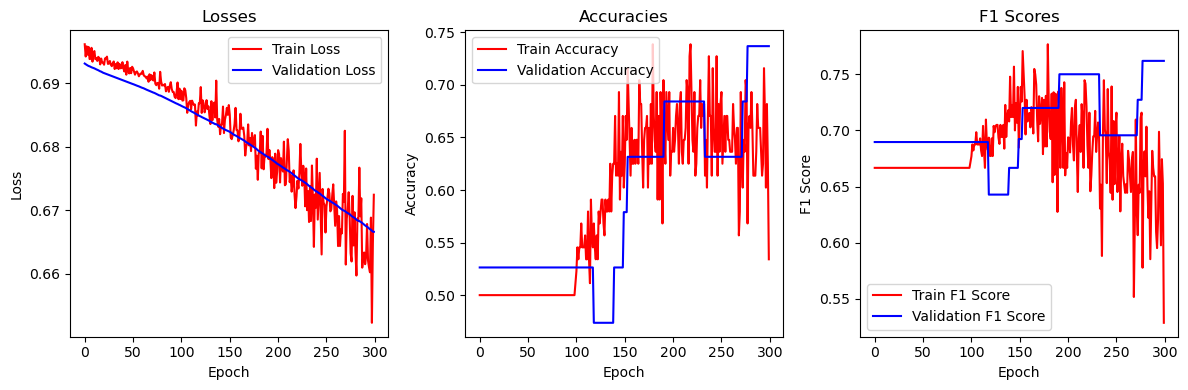

In [21]:
# Those model data are kept from the previius part to ensure smooth model creation
# If you want to run only part3, use the following params:

# lr = 0.00001
# model = GNN(
#    num_features=MUTAG_NUM_FEATURES,
#    num_classes=MUTAG_NUM_CLASSES,
#    normal_conv_dims=[],
#    attn_dims=[],
#    sage_data=[(128, MaxPoolAggregation()), (8, MaxPoolAggregation())],
#    name="GNN-Edge-Features",
# )

lr = best_perfoming_models_metadata["sage"][4]

model = GNN(
    num_features=MUTAG_NUM_FEATURES,
    num_classes=MUTAG_NUM_CLASSES,
    normal_conv_dims=best_perfoming_models_metadata["sage"][0],
    attn_dims=best_perfoming_models_metadata["sage"][1],
    sage_data=best_perfoming_models_metadata["sage"][2],
    name="GNN-Edge-Features",
)

# Set the hyperparameters
epochs = 300
verbose = True
criterion = nn.CrossEntropyLoss()
features_key = "concat_feats"

# Initialize the optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Train the new model
results = train_utils.train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs,
    criterion,
    optimizer,
    verbose,
    features_key,
    # scheduler, # Uncomment to use scheduler
)

# Calculate and examine the results
acc, _, f1, _, _ = train_utils.test(test_dataloader, model, criterion, features_key)

print()
print("======== RESULTS =========")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# And also plot the training results!
utils.plot_training_loop_summary(results, None)

We see that the enhanced feature matrix leads to worse performance compared to using only the node features, as the new model scores 63% accuracy, while the initial model using only the node features managed to achieve up to 79% accuracy on the same testing data.